Imports

In [1]:
import feed_forward
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import geoopt
from time import time
from torchvision import datasets, transforms
import helper
torch.cuda.is_available()

True

CUDA check

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

Data Transformation

In [3]:
transform = transforms.Compose([transforms.ToTensor(),
                                #transforms.Normalize((0.1307,), (0.3081,)), 
                              ])

Training and Test data from MNIST data set

In [4]:
trainset = datasets.KMNIST('PATH_TO_STORE_TRAINSET', download=True, train=True, transform=transform)
valset = datasets.KMNIST('PATH_TO_STORE_TESTSET', download=True, train=False, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=512, shuffle=True)
valloader = torch.utils.data.DataLoader(valset, batch_size=512, shuffle=True)

100.0%


Extracting PATH_TO_STORE_TRAINSET\KMNIST\raw\train-images-idx3-ubyte.gz to PATH_TO_STORE_TRAINSET\KMNIST\raw



100.7%


Extracting PATH_TO_STORE_TRAINSET\KMNIST\raw\train-labels-idx1-ubyte.gz to PATH_TO_STORE_TRAINSET\KMNIST\raw



100.0%


Extracting PATH_TO_STORE_TRAINSET\KMNIST\raw\t10k-images-idx3-ubyte.gz to PATH_TO_STORE_TRAINSET\KMNIST\raw



100.0%
C:\Users\julia\AppData\Local\Programs\Python\Python39\lib\site-packages\torchvision\datasets\mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ..\torch\csrc\utils\tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


Extracting PATH_TO_STORE_TRAINSET\KMNIST\raw\t10k-labels-idx1-ubyte.gz to PATH_TO_STORE_TRAINSET\KMNIST\raw



100.0%


Extracting PATH_TO_STORE_TESTSET\KMNIST\raw\train-images-idx3-ubyte.gz to PATH_TO_STORE_TESTSET\KMNIST\raw



100.7%


Extracting PATH_TO_STORE_TESTSET\KMNIST\raw\train-labels-idx1-ubyte.gz to PATH_TO_STORE_TESTSET\KMNIST\raw



100.0%


Extracting PATH_TO_STORE_TESTSET\KMNIST\raw\t10k-images-idx3-ubyte.gz to PATH_TO_STORE_TESTSET\KMNIST\raw



100.0%

Extracting PATH_TO_STORE_TESTSET\KMNIST\raw\t10k-labels-idx1-ubyte.gz to PATH_TO_STORE_TESTSET\KMNIST\raw



Initializing the model

In [5]:
model = feed_forward.HypFF(784, 512, 256, 10, nn.ReLU())
model.to(device)

HypFF(
  (act_fn): ReLU()
  (fc1): MobLinear(
    in_features=784, out_features=512, bias=True
    (ball): PoincareBall manifold
  )
  (fc2): MobLinear(
    in_features=512, out_features=256, bias=True
    (ball): PoincareBall manifold
  )
  (fc3): MobLinear(
    in_features=256, out_features=10, bias=True
    (ball): PoincareBall manifold
  )
)

In [6]:
print(model)

HypFF(
  (act_fn): ReLU()
  (fc1): MobLinear(
    in_features=784, out_features=512, bias=True
    (ball): PoincareBall manifold
  )
  (fc2): MobLinear(
    in_features=512, out_features=256, bias=True
    (ball): PoincareBall manifold
  )
  (fc3): MobLinear(
    in_features=256, out_features=10, bias=True
    (ball): PoincareBall manifold
  )
)


Hyperparameters

In [7]:
#learning_rate = 8e-1 
learning_rate = 2e-1 #learning rate for ReLU activation function
#learning_rate = 2e-1 #current learning rate for model without activation functions
momentum = 0.9

Loss Function

In [8]:
criterion = nn.CrossEntropyLoss()

tensor([[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0231, 0.0000, 0.0000],
        ...,
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],
       device='cuda:0')
tensor([[ 0.0181, -0.0250, -0.0474,  ...,  0.0545,  0.0337, -0.0276],
        [ 0.0166, -0.0260, -0.0491,  ...,  0.0478,  0.0311, -0.0256],
        [ 0.0219, -0.0251, -0.0460,  ...,  0.0527,  0.0251, -0.0278],
        ...,
        [ 0.0145, -0.0258, -0.0482,  ...,  0.0547,  0.0307, -0.0275],
        [ 0.0184, -0.0262, -0.0478,  ...,  0.0499,  0.0316, -0.0301],
        [ 0.0183, -0.0274, -0.0500,  ...,  0.0503,  0.0278, -0.0262]],
       device='cuda:0', grad_fn=<SWhereBackward>)


Optimizer

In [9]:
optimizer = geoopt.optim.RiemannianSGD(model.parameters(), lr=learning_rate, momentum=momentum)

In [10]:

time0 = time()

epochs = 10
for e in range(epochs):
    running_loss = 0
    for images, labels in trainloader:
        images, labels = images.to(device), labels.to(device)
        # Flatten MNIST images into a 784 long vector
        images = 0.0357*images.view(images.shape[0], -1)
    
        # Training pass
        optimizer.zero_grad()
        
        output = model(images)
        loss = criterion(output, labels)
        
        #backpropagation
        loss.backward()
        
        #Weight optimization
        optimizer.step()
        
        running_loss += loss.item()
    else:
        print("Epoch {} - Training loss: {}".format(e, running_loss/len(trainloader)))
print("\nTraining Time (in minutes) =",(time()-time0)/60)

Epoch 0 - Training loss: 2.068126487529884
Epoch 1 - Training loss: 1.642362650168144
Epoch 2 - Training loss: 1.5449403736550928
Epoch 3 - Training loss: 1.5019976476491508
Epoch 4 - Training loss: 1.4799894720821056
Epoch 5 - Training loss: 1.4674443905636416
Epoch 6 - Training loss: 1.4574588890803062
Epoch 7 - Training loss: 1.4506315760693307
Epoch 8 - Training loss: 1.445673509169433
Epoch 9 - Training loss: 1.4416773218219563

Training Time (in minutes) = 2.5147946159044903


tensor([[-0.0867, -0.1130,  0.9380, -0.1204, -0.1561, -0.1312, -0.0604, -0.1051,
         -0.1450, -0.0124]])
[-0.08668253, -0.11302746, 0.9379509, -0.12041759, -0.15612562, -0.13124092, -0.060391564, -0.105134346, -0.14498746, -0.012384059]
Predicted Digit = 2


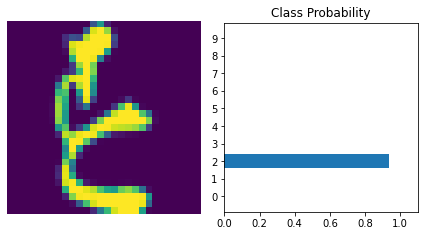

In [16]:
images, labels = next(iter(valloader))
#images, labels = images.to(device), labels.to(device)

img = 0.0357*images[0].view(1, 784)
img_gpu = img.to(device)
with torch.no_grad():
    out = model(img_gpu)

ps = out.cpu()
print(ps)
probab = list(ps.numpy()[0])
print(probab)
print("Predicted Digit =", probab.index(max(probab)))
helper.view_classify(img.view(1, 28, 28), ps)

In [12]:
correct_count, all_count = 0, 0
for images,labels in valloader:
  images, labels = images.to(device), labels.to(device)
  for i in range(len(labels)):
    img = 0.0357*images[i].view(1, 784)
    with torch.no_grad():
        out = model(img)

    
    ps = out.cpu()
    probab = list(ps.numpy()[0])
    pred_label = probab.index(max(probab))
    true_label = labels.cpu().numpy()[i]
    if(true_label == pred_label):
      correct_count += 1
    all_count += 1

print("Number Of Images Tested =", all_count)
print("\nModel Accuracy =", (correct_count/all_count))

Number Of Images Tested = 10000

Model Accuracy = 0.8997


Current status of experiments:
1. Using just Hyperboic Linear modules, and with the appropriate self-tuned hyperparameters, and a batch size of 512, the average accuracy was around 90 percent
2. With the use of activation functions(ReLu, ReLu, then LogSoftMax at the output layer), (by applying the functions in the tangent space, then mapping it back to the hyperbolic space), we see an increase in the model accuracy to about 97-98 percent.
3. To account for the correct class probabilities , linear layer was used as the output layer instead, together with the crossentropy loss function.